In [1]:
#Imports and dependencies
import os
from os.path import join, abspath, dirname
import sys
sys.path.insert(0, abspath(join("..", dirname(os.getcwd()))))

import torch
import torch.nn as nn
import math
import pandas as pd
import random
import imageio
from skimage import img_as_ubyte
from scipy.ndimage.morphology import binary_dilation
from itertools import product
from typing import List
from tqdm import tqdm_notebook
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.renderer import (
    SfMPerspectiveCameras, OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex, HardFlatShader
)
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency
)
from torchvision import transforms

from dataclasses import dataclass, field, asdict, astuple
import numpy as np
#Plotting Libs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import time
from copy import deepcopy

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from utils.visualization import plot_pointcloud
from utils.shapes import Sphere, SphericalSpiral
from utils.manager import RenderManager, ImageManager

In [2]:
#Matplotlib config nums
mpl.rcParams['savefig.dpi'] = 90
mpl.rcParams['figure.dpi'] = 90
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0": torch.cuda.set_device()

### Create a Renderer

In [3]:
img_size = (64, 64)

cameras = SfMPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=img_size[0], 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=img_size[0], 
    blur_radius=1e-5, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(
    device=device, 
    location=[[3.0, 3.0, 0.0]], 
    diffuse_color=((1.0, 1.0, 1.0),),
    specular_color=((1.0, 1.0, 1.0),),
)
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardFlatShader(device=device, lights=lights, cameras=cameras)
)

### Event Renderer

In [4]:
ON = 254
OFF = 0
threshold = 254.5/255

def gray(img):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

def event_renderer(img1, img2, render_type):
    
    if render_type == "phong":
        img1 = gray(img1)
        img2 = gray(img2)
        
    diff_frames = img2 - img1
    
    threshold_diff = (diff_frames < threshold) * diff_frames

    tanh_diff = np.tanh(threshold_diff)
    #tanh_diff = np.where(tanh_diff != 0, OFF, ON)
    
    return tanh_diff

### Create a trajectory and Render

### Diff Model

In [5]:
def neg_iou_loss(predict, target):
    dims = tuple(range(predict.ndimension())[1:])
    intersect = (predict * target).sum(dims)
    union = (predict + target - predict * target).sum(dims) + 1e-6
    return 1. - (intersect / union).sum() / intersect.nelement()

In [6]:
class MeshDeformationModel(nn.Module):
    
    def __init__(self, device, template_mesh = None):
        super().__init__()
        
        self.device = device
        
        #Create a source mesh
        if not template_mesh:
            template_mesh = ico_sphere(2, device)
        
        verts, faces = template_mesh.get_mesh_verts_faces(0)
        #Initialize each vert to have no tetxture
        verts_rgb = torch.ones_like(verts)[None]
        textures = TexturesVertex(verts_rgb.to(self.device))
        self.template_mesh = Meshes(
            verts=[verts.to(self.device)],
            faces=[faces.to(self.device)],
            textures = textures
        )
        
        self.register_buffer('vertices', self.template_mesh.verts_padded() * 1.3)
        self.register_buffer('faces', self.template_mesh.faces_padded())
        self.register_buffer('textures', textures.verts_features_padded())
        
        deform_verts = torch.zeros_like(self.template_mesh.verts_packed(), device=device, requires_grad=True)
        #deform_verts = torch.full(self.template_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
        #Create an optimizable parameter for the mesh
        self.register_parameter('deform_verts', nn.Parameter(deform_verts).to(self.device))
        
        laplacian_loss = mesh_laplacian_smoothing(template_mesh, method="uniform")
        flatten_loss = mesh_normal_consistency(template_mesh)
        
    def forward(self, batch_size):
        #Offset the mesh
        deformed_mesh_verts = self.template_mesh.offset_verts(self.deform_verts)
        texture = TexturesVertex(self.textures)
        deformed_mesh = Meshes(verts=deformed_mesh_verts.verts_padded(), faces=deformed_mesh_verts.faces_padded(), textures=texture)
        deformed_meshes = deformed_mesh.extend(batch_size)
    
        laplacian_loss = mesh_laplacian_smoothing(deformed_mesh, method="uniform")
        flatten_loss = mesh_normal_consistency(deformed_mesh)
        
        return deformed_meshes, laplacian_loss, flatten_loss
    

# IMAGE-BASED
### Initialize the model

In [7]:
def sample_tensor(t, batch_size, indices = None):
    l = t.shape[0]
    if l < batch_size:
        return
    if not indices:
        step = int(l / batch_size)
        start = random.randint(0, step - 1)
        indices = list(range(start, l, step))
    return t[indices]

In [8]:
weight_silhouette = 1
weight_laplacian = .1
weight_flatten = .001

batch_size = int(360/ 6) #=60

# We will save images periodically and compose them into a GIF.
filename_output = "./projection_loss.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.1)

#Create a loss plotting object
#loss_ax = plot_loss(num_losses = 3)

# Initialize a model using the renderer, template mesh and reference image
model = MeshDeformationModel(device).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=.001, betas=(0.5, 0.99)) #Hyperparameter tuning

#render = RenderManager.from_directory(dir_num=60)
render = RenderManager.from_path("../data/renders/test_dolphin/002-dolphin_2020-09-23T11:45:50/")
R, T = render._trajectory
R = sample_tensor(R, batch_size)
T = sample_tensor(T, batch_size)

images_gt = render._images(type_key="silhouette_pred", img_size = img_size).to(device)
images_gt = sample_tensor(images_gt, batch_size)

cameras = SfMPerspectiveCameras(device=device, R=R, T=T)

### Run Optimization

/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



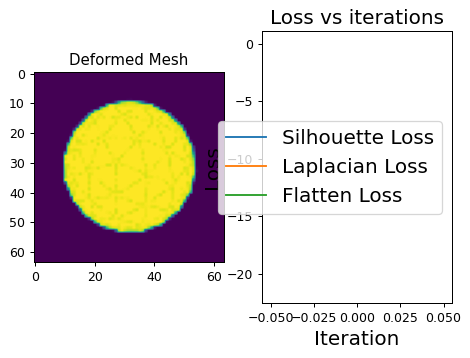

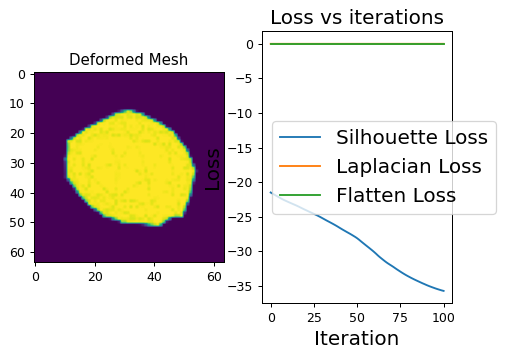

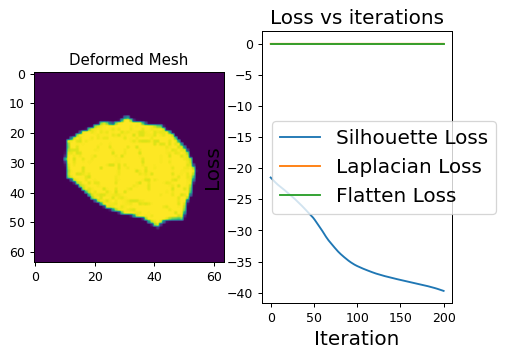

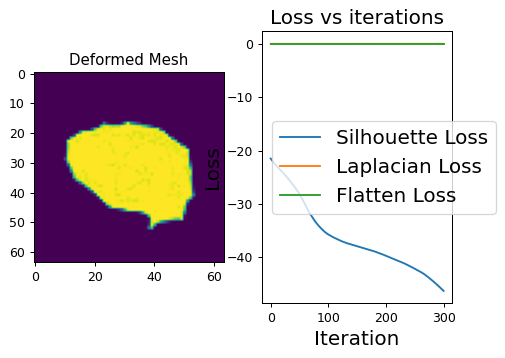

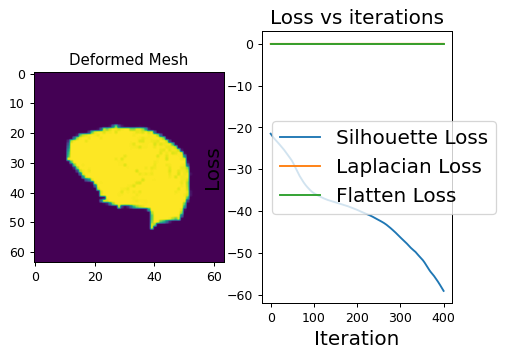

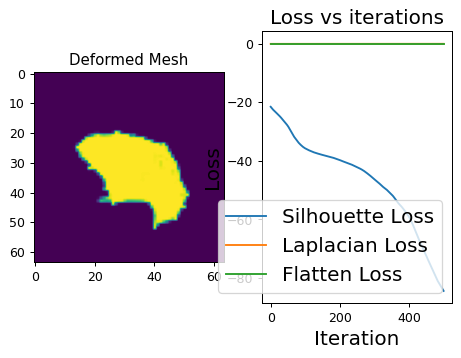

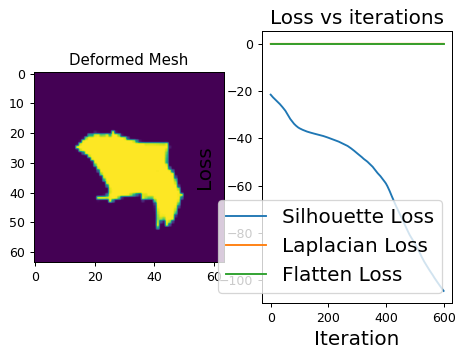

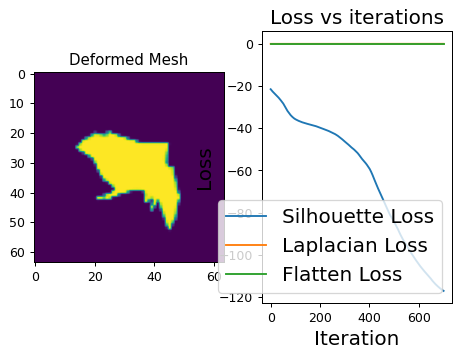

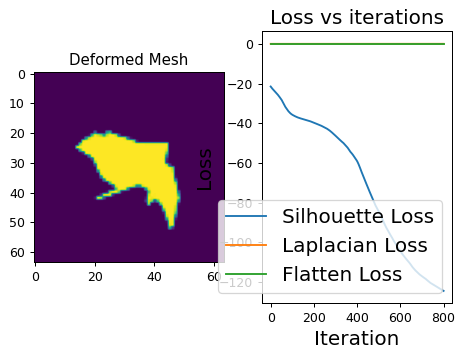

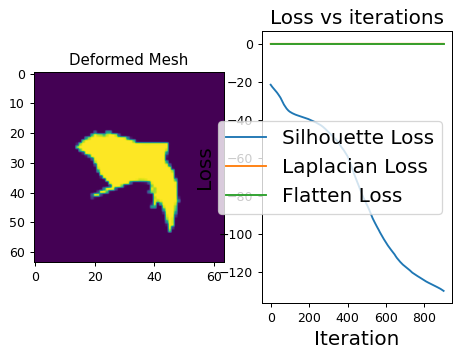

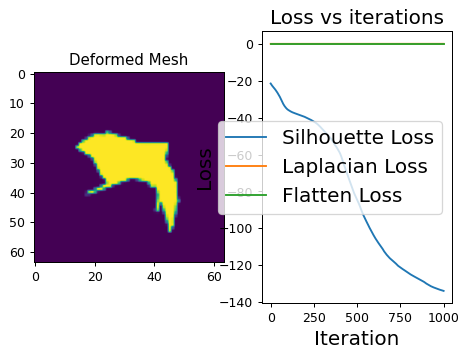

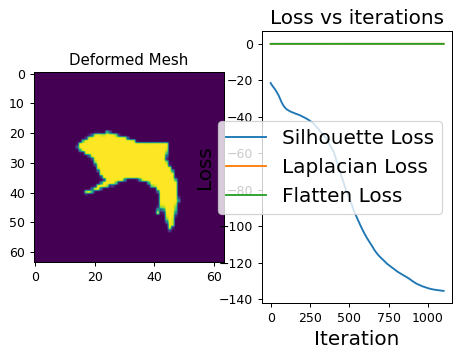

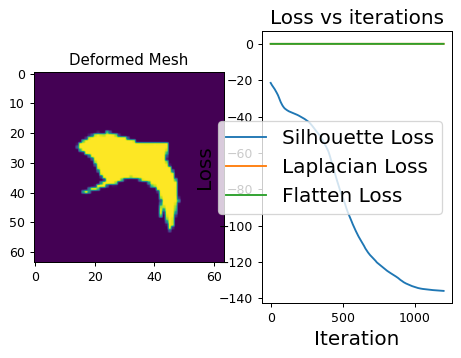

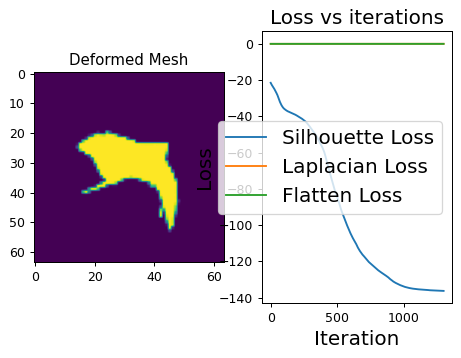

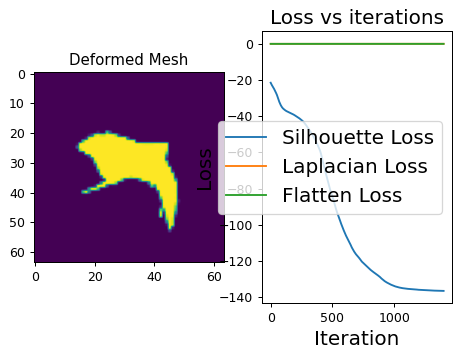

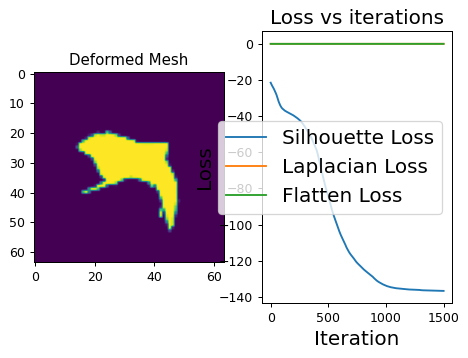

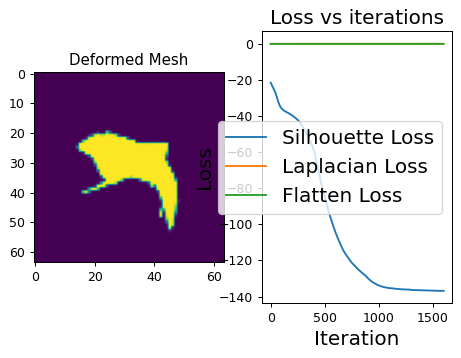

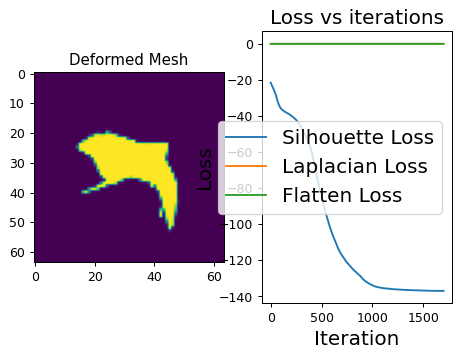

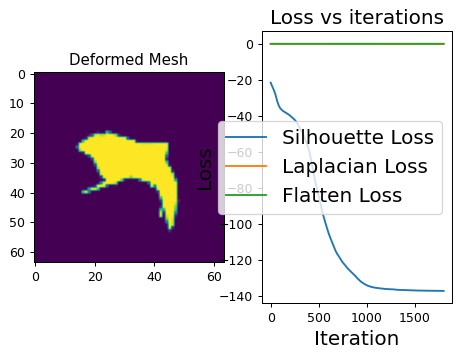

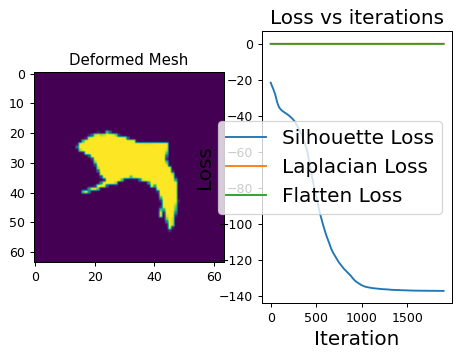

In [9]:
experiment_name = "random_indices"2
tests_path = "../data/tests/dolpihn-sep23-baseline"
path = join(tests_path, experiment_name)
os.makedirs(path)

loop = tqdm_notebook(range(2000))
laplacian_losses = []
flatten_losses = []
silhouette_losses = []

for i in loop:
    
    mesh, laplacian_loss, flatten_loss = model(batch_size)

    images_pred = silhouette_renderer(mesh.clone(), device=device, cameras=cameras)
    
    silhouette_loss = neg_iou_loss(images_gt, images_pred[...,-1])
    #ssd_loss = torch.sum((images_gt - images_pred[...,-1]) ** 2).mean()
    
    loss = silhouette_loss * weight_silhouette + laplacian_loss * weight_laplacian + flatten_loss * weight_flatten
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    silhouette_losses.append(silhouette_loss * weight_silhouette)
    laplacian_losses.append(laplacian_loss * weight_laplacian)
    flatten_losses.append(flatten_loss * weight_flatten)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        #Write images
        image = images_pred.detach().cpu().numpy()[0][...,-1]
        
        writer.append_data((255*image).astype(np.uint8))
        imageio.imsave(f"../data/dump/mesh_{i}.png", (255*image).astype(np.uint8))
        
        f, (ax1, ax2) = plt.subplots(1, 2)
        
        image = img_as_ubyte(image)
        ax1.imshow(image)
        ax1.set_title("Deformed Mesh")
        
        ax2.plot(silhouette_losses, label="Silhouette Loss")
        ax2.plot(laplacian_losses, label="Laplacian Loss")
        ax2.plot(flatten_losses, label="Flatten Loss")
        ax2.legend(fontsize="16")
        ax2.set_xlabel("Iteration", fontsize="16")
        ax2.set_ylabel("Loss", fontsize="16")
        ax2.set_title("Loss vs iterations", fontsize="16")
        
        plt.show()
    